In [31]:
import numpy as np
from sklearn import datasets
from scipy.spatial.distance import pdist,squareform
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import networkx as nx

In [2]:
from tmap.tda.metric import Metric
from tmap.tda import mapper, Filter
from tmap.tda.cover import Cover
from tmap.tda.plot import Color

2024-02-18 19:46:29.881657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
import community as community_louvain

def _get_communities(G):
    partition = community_louvain.best_partition(G, resolution=1.0, randomize=False)
    v = {}

    for key, value in partition.items():
        v.setdefault(value, set()).add(key)

    communities = [i for i in v.values()]

    y_fake = np.zeros(G.number_of_nodes()) - 1

    for cls_idx, items_idx in enumerate(communities):
        y_fake[list(items_idx)] = int(cls_idx)

    modularity = nx.community.modularity(G, communities)
    return y_fake, modularity

In [4]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [5]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [51]:
iris = datasets.load_iris()
X = iris.data

# distance matrix
D = squareform(pdist(X, metric="braycurtis"))

print(X.shape)
X[0:5]

(150, 4)


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [6]:
X = data.x.numpy()
y = data.y.numpy()
print(X.shape)
X[0:5]

(2708, 1433)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
D = squareform(pdist(X, metric="cosine"))

Filtering by UMAP.
...calculate Filter(which used to create cover) using the provided precomputed lens.


/home/marcos/miniconda3/envs/deep_graph_clustering/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning:

using precomputed metric; inverse_transform will be unavailable



Filtering has been completed.
------------> projection in 2D
(2708, 2)


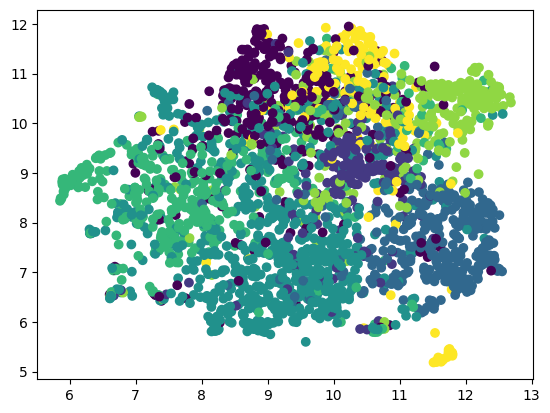

In [27]:
# Step1. initiate a Mapper
tm = mapper.Mapper(verbose=1)

# Step2. Projection
lens = [Filter.UMAP(metric=Metric('precomputed'))]
projected_X = tm.filter(D, lens=lens)

print('------------> projection in 2D')
print(projected_X.shape)

plt.scatter(projected_X[:, 0], projected_X[:, 1], c=y)

In [28]:
# Step3. Create Cover
cover = Cover(projected_data=projected_X, resolution=20, overlap=0.75)

# Step4. Create Graph
# clusterer = DBSCAN(eps=0.75, min_samples=1)
graph = tm.map(data=projected_X, cover=cover)

print(len(graph.nodes),len(graph.edges))

100%|███████████████████████████████████████| 400/400 [00:00<00:00, 1220.86it/s]


Mapping on data (2708, 2) using lens (2708, 2)
...minimal number of points in hypercube to do clustering: 1
...create 350 nodes.
...calculate projection coordinates of nodes.
...construct a TDA graph.
...create 3344 edges.
Finish TDA mapping
350 3344


In [45]:
A = nx.adjacency_matrix(graph).toarray()
G = nx.from_numpy_array(A)
y_fake, modularity = _get_communities(G)

In [47]:
A.shape

(350, 350)

In [49]:
len(graph)

350

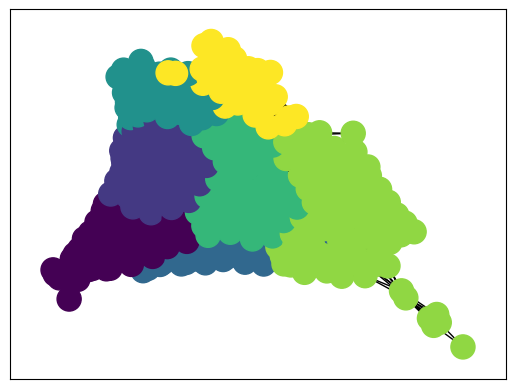

In [61]:
color = Color(target=y_fake)
nx.draw_networkx(G, node_color=y_fake, with_labels=False)


# graph.show(color=color, fig_size=(10, 10), node_size=15)